## Anomaly Score 받아오기

In [1]:
import shutil

In [2]:
# argument
dataset_type = 'one'

In [3]:
import numpy as np
import pandas as pd

ano_score = np.load(f'save/{dataset_type}_class/3_13_efficientnet_b6/det_mult_anomaly_scores.npy')
print(len(ano_score))

361


#

## Label 값 받아오기

In [4]:
DATASET_PATH = f'/tf/KAIER_2022/Battery_data/무지부_코팅부/무지부'

from glob import glob
import os
def get_label():
    mode = 'test'
    
    if dataset_type == 'multi':
        normal_names = ['코팅부 경계부 불량', '무지부 줄무늬', '코팅부 접힘', '코팅부 미코팅', '코팅부 줄무늬', '코팅부 테이프', \
                     '코팅부 기재연결부', '무지부 기재연결부', '코팅부 코팅불량']
        abnormal_names = ['코팅부 버블', '코팅부 흑점', '무지부 주름', '코팅부 찍힘', '코팅부 백점', '코팅부 라벨지']
    elif dataset_type == 'one':
        normal_names = ['무지부 줄무늬']
        abnormal_names = ['무지부 주름']

#     normal_paths = []
#     for name in normal_names:
#         fpattern = os.path.join(DATASET_PATH, f'{mode}/{name}/*.bmp')
#         fpaths = sorted(glob(fpattern))
# #         print(len(fpaths))
#         normal_paths += fpaths
    
#     abnormal_paths = []
#     for name in abnormal_names:
#         fpattern = os.path.join(DATASET_PATH, f'{mode}/{name}/*.bmp')
#         fpaths = sorted(glob(fpattern))
# #         print(len(fpaths))
#         abnormal_paths += fpaths

    fpattern = os.path.join(DATASET_PATH, f'{mode}/*/*.bmp')
    fpaths = sorted(glob(fpattern))
    
    # get only label name in data path 
    def split(x):
        return x.split('/')[-2]    

    test_class_list = list(map(split, fpaths))
    
    def change_name_to_label(x):
        if x in normal_names:
            return 0
        else:
            return 1

    test_label_list = list(map(change_name_to_label, test_class_list))

    return test_label_list, test_class_list, fpaths

In [52]:
label, classes, paths = get_label()
# print(label)

In [53]:
new_idx = np.where(np.array(label)==0)[0][:12]
label = np.array(label)
label = label[:new_idx[-1]+1]
ano_score = ano_score[:new_idx[-1]+1]

In [54]:
len(ano_score)

24

In [47]:
new_idx[-1]

23

In [55]:
np.unique(label, return_counts=True)

(array([0, 1]), array([12, 12]))

In [7]:
len(ano_score)

361

In [8]:
len(label)

361

In [9]:
# AUROC 확인
from sklearn.metrics import roc_auc_score
print(roc_auc_score(label, ano_score))

0.9921203438395415


In [10]:
# Anomaly Score 확인
print(ano_score)

[1692.65389943 1378.8304901  1597.58361963 1461.44186349 1464.25939554
 1321.52444992 1979.11977778 1965.67418676 2870.21767999 1262.32441369
 1995.31177579 1996.74953226 1667.52296361  688.15252874 1799.07447457
  760.62318914  762.70840234  982.59683543  721.55412748  906.65437318
  771.24764787  697.33811439  682.7184997  1019.34412927  715.76643729
  730.87184371  862.49722333  722.30765201  811.03342622  773.36627103
  645.04038724  608.45726963  996.58031756  625.83839294  738.98636512
  731.52271475 1297.45004973  809.2005674   793.00488828 1042.99109629
  544.998669    947.49974179  713.54644485 1215.59152011  581.84594865
  582.62276226  591.57990639  589.03384837  429.49368124  433.68548873
 1078.60958083  438.94108964  503.42735542  472.4961919   473.77583145
  473.3056483   716.30294837  522.29967639  557.8784391   751.6347945
  755.27555848  566.73702583  669.6051634   456.77450483  622.08253378
  495.67536695 1023.40907113  553.34114774  812.79067011  947.05859857
  760.2

## Threshold 잡기

max(tpr_fpr)가 되는 지점의 threshold

In [56]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(label, ano_score)
J = tpr-fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]


print("index : ", ix)
print("Best Threshold: ", best_thresh)
print("tpr: ", tpr[ix])
print("fpr: ", fpr[ix])

index :  6
Best Threshold:  1262.3244136930152
tpr:  1.0
fpr:  0.16666666666666666


In [57]:
# for thres in thresholds:
#     pred = ano_score > thres
#     pred = list(map(int, pred))
#     print("accuracy score: {}" .format(accuracy_score(label, pred)))

## ROC Curve

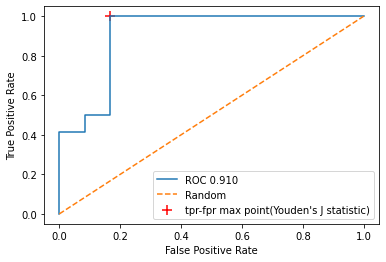

In [58]:
import matplotlib.pyplot as plt

plt.plot(fpr, tpr, label = f"ROC {roc_auc_score(label, ano_score):.3f}")
plt.scatter(fpr[ix], tpr[ix], marker = '+', s = 100, color = 'r', label = "tpr-fpr max point(Youden's J statistic)")
# plt.scatter(fpr[103], tpr[103], marker = '+', s = 100, color = 'black', label = 'fpr 0.2 point')
plt.plot([0.0, 1.0], [0.0, 1.0], '--', label = "Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

In [59]:
# Threshold를 반영한 예측값
pred = ano_score > best_thresh
print(pred)

[ True  True  True  True  True  True  True  True  True False  True  True
  True False  True False False False False False False False False False]


In [60]:
pred = list(map(int, pred))

In [61]:
from sklearn.metrics import roc_auc_score, recall_score, precision_score, accuracy_score
import scikitplot as skplt 

accuracy score: 0.875
recall: 0.9166666666666666
preicision: 0.8461538461538461


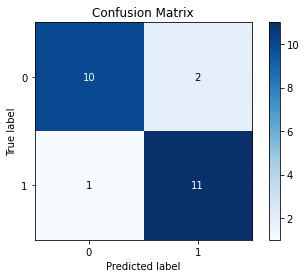

In [62]:
skplt.metrics.plot_confusion_matrix(y_true=label,y_pred=pred)
# plt.savefig(os.path.join(test_score_path, 'confusion_matrix.png'))
print("accuracy score: {}" .format(accuracy_score(label, pred)))
print("recall: {}" .format(recall_score (label, pred)))
print("preicision: {}" .format(precision_score(label, pred)))

In [63]:
ano_score[np.array(classes) == '코팅부 경계부 불량']

IndexError: boolean index did not match indexed array along dimension 0; dimension is 24 but corresponding boolean dimension is 361

In [ ]:
ano_score[np.array(classes) == '코팅부 흑점']

In [ ]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(label, pred)
print(matrix)

TN = matrix[0][0]
FP = matrix[0][1]
FN = matrix[1][0]
TP = matrix[1][1]

print("False Negative, 이상을 정상으로 예측한 경우: ", FN, "건")
print("True Negative, 정상을 정상으로 예측한 경우: ", TN, "건")
print("False Positive, 정상을 이상으로 예측한 경우: ", FP, "건")
print("True Positive, 이상을 이상으로 예측한 경우: ", TP, "건")

In [ ]:
def check_false(pred,label, type_='positive'):
    if type_ == 'positive':
        _idx = np.where((np.array(pred)==1)&(np.array(label)==0))[0]
    else:
        _idx = np.where((np.array(pred)==0)&(np.array(label)==1))[0]
    
    print("false {}: {}" .format(type_, len(_idx)))
    
    false_unique = np.unique(np.array(classes)[_idx], return_counts=True)
    false_cls_name = false_unique[0]
    false_count = false_unique[1]
    
    return pd.DataFrame({'class':false_cls_name, 'count':false_count}).sort_values(by=['count'], ascending=False)

In [ ]:
false_df = check_false(pred, label, type_='positive')

In [ ]:
false_df

In [ ]:
fp_idx = np.where((np.array(pred)==1)&(np.array(label)==0))[0]

In [ ]:
fp_unique = np.unique(np.array(classes)[fp_idx], return_counts=True)
fp_cls_name = fp_unique[0]
fp_count = fp_unique[1]

In [ ]:
pd.DataFrame({'class':fp_cls_name, 'count':fp_count}).sort_values(by=['count'], ascending=False)

## PRAUC 

In [ ]:
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.metrics import auc, plot_precision_recall_curve
from numpy import argmax

In [ ]:
# Data to plot precision - recall curve
precision, recall, thresholds = precision_recall_curve(label, ano_score)
# Use AUC function to calculate the area under the curve of precision recall curve
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)

# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# replace nan to 0
def delete_nan(x):
    if x != x:
        return 0 
    else:
        return x
new_fscore = list(map(delete_nan, fscore))
# locate the index of the largest f score
ix = argmax(new_fscore)

In [ ]:
plt.plot(recall, precision, label='PRAUC:{:.3f}'.format(auc_precision_recall))
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
plt.xlabel("recall")
plt.ylabel("precision")
plt.legend()
plt.show()

In [ ]:
best_threshold = thresholds[ix]
print("PR_AUC best threshold: {}".format(best_threshold))

In [ ]:
# Threshold를 반영한 예측값
pred = ano_score > best_threshold
print(pred)

pred = list(map(int, pred))

print("accuracy score: {}" .format(accuracy_score(label, pred)))
print("recall: {}" .format(recall_score (label, pred)))
print("preicision: {}" .format(precision_score(label, pred)))

In [ ]:
skplt.metrics.plot_confusion_matrix(y_true=label,y_pred=pred)

In [424]:
np.array(paths)[(np.array(pred)==1)&(np.array(label)==0)]

array(['/tf/KAIER_2022/Battery_data/one_class/test_100_samples/코팅부 경계부 불량/5_369_2.bmp',
       '/tf/KAIER_2022/Battery_data/one_class/test_100_samples/코팅부 경계부 불량/5_602_10.bmp',
       '/tf/KAIER_2022/Battery_data/one_class/test_100_samples/코팅부 경계부 불량/6_3130_7.bmp',
       '/tf/KAIER_2022/Battery_data/one_class/test_100_samples/코팅부 경계부 불량/6_3351_11.bmp'],
      dtype='<U85')

In [287]:
len(ano_score)

4618

In [538]:
classes = np.array(classes)

In [541]:
# score 이용하여 100개 뽑기 
new_idx = []
new_label = []
for x in np.unique(classes):
    class_idx = np.where(classes == x)[0]
    print(x, len(class_idx))
    class_ano_score = ano_score[class_idx]
    
    if x in ['코팅부 경계부 불량']:
        # 정상 클래스는 ano score가 낮은 순서대로 가져옴 
        sorted_idx = np.argsort(class_ano_score)[:20]
        y_label = 0
    elif x in ['코팅부 백점', '코팅부 라벨지']:
        sorted_idx = np.argsort(class_ano_score)[-4:]
        y_label = 1
    else:
        sorted_idx = np.argsort(class_ano_score)[-6:]
        y_label = 1
    
    new_idx += class_idx[sorted_idx].tolist()
    new_label += [y_label]*len(sorted_idx)
    
#     if x == '코팅부 경계부 불량':
#         break


무지부 기재연결부 59
무지부 주름 12
무지부 줄무늬 1394
코팅부 경계부 불량 1359
코팅부 기재연결부 82
코팅부 라벨지 4
코팅부 미코팅 454
코팅부 백점 5
코팅부 버블 28
코팅부 접힘 678
코팅부 줄무늬 247
코팅부 찍힘 6
코팅부 코팅불량 42
코팅부 테이프 235
코팅부 흑점 13


In [531]:
# new_idx = []
# new_label = []
# equal_idx = np.where(np.array(pred) == np.array(label))
# for x in np.unique(classes):
#     class_idx = np.where(classes == x)[0]
    
#     right_idx = class_idx[np.in1d(class_idx, equal_idx)].tolist()
    
#     if x in ['코팅부 경계부 불량']:
#         right_idx = right_idx[:11]
#     elif x in ['코팅부 백점', '코팅부 라벨지', '코팅부 찍힘']:
#         right_idx = right_idx[:4]
#     else:
#         right_idx = right_idx[:7]
    
#     new_idx += right_idx
#     new_label += [x]*len(right_idx)
# #     if x == '코팅부 경계부 불량'
#     #     break

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


In [503]:
len(new_idx)

100

In [394]:
class_idx[np.in1d(class_idx, equal_idx)]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58])

In [527]:
class_ano_score[sorted_idx] # 정상

array([694.10587532, 703.25036946, 714.09969765, 717.35089785,
       722.40608834, 723.26283924, 723.77636757, 731.28085973,
       731.80286577, 733.35818624, 733.51803788, 733.75403336,
       733.76649225, 738.80659945, 738.87096382, 739.8474825 ,
       741.47410404, 741.56944431, 742.14101871, 742.15544696])

In [529]:
class_ano_score[sorted_idx] # 코팅부 흑점

array([2661.90093849, 2749.36164358, 3530.26952524, 3640.43112038,
       3920.97490675, 4250.14444047])

In [545]:
print(roc_auc_score(new_label, ano_score[new_idx]))
# ano_score[new_idx], new_label

1.0


In [293]:
class_ano_score[sorted_idx]

array([2645.2312984 , 3116.03903403, 3461.09972491, 3480.3896733 ,
       3944.52345486, 4261.8033418 ])

In [295]:
len(new_idx)

100

In [521]:
# 폴더 만들기 
normal_names = ['코팅부 경계부 불량', '무지부 줄무늬', '코팅부 접힘', '코팅부 미코팅', '코팅부 줄무늬', '코팅부 테이프', \
                     '코팅부 기재연결부', '무지부 기재연결부', '코팅부 코팅불량']
abnormal_names = ['코팅부 버블', '코팅부 흑점', '무지부 주름', '코팅부 찍힘', '코팅부 백점', '코팅부 라벨지']

folder_names = normal_names + abnormal_names
for fold in folder_names:
    os.makedirs(f'/tf/KAIER_2022/Battery_data/one_class/test_100_samples_2/{fold}')

In [103]:
x.split('/')[-2]

'무지부 기재연결부'

In [546]:
for x in np.array(paths)[new_idx]:
    class_ = x.split('/')[-2]
    file = x.split('/')[-1]
    shutil.copy(x, f'/tf/KAIER_2022/Battery_data/one_class/test_100_samples_2/{class_}/{file}')

In [466]:
x

'/tf/KAIER_2022/Battery_data/one_class/test/무지부 주름/4_12355_1.bmp'

In [431]:
len(paths)

100

In [244]:
len(new_idx)

100

In [89]:
class_idx[sorted_idx].tolist()

[57, 23, 19, 38, 54, 27]

In [77]:
np.argsort(class_ano_score)  # score가 작은 순서대로 

array([31, 45, 13, 14, 10,  3, 12, 32, 53,  4, 44, 39, 56,  1, 17, 18, 51,
       22, 41, 40, 29, 16, 50, 46,  2, 52, 47,  5, 48, 49, 35,  8, 26, 21,
       15, 43,  9, 25, 55, 37,  0, 11, 24, 28, 36,  7, 42, 20, 58, 30, 34,
        6, 33, 57, 23, 19, 38, 54, 27])

In [80]:
class_ano_score[31]

1297.3591038482264

In [68]:
class_idx

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58]),)

## visualize anomaly score

In [183]:
ano_score[np.array(label)==0]

array([2308.70051471,  784.16123847,  848.73906544,  905.86753596,
        795.92068338,  789.38830771,  996.20984102,  847.70837251,
        757.55157886,  801.8608508 ,  754.08585671,  763.12339638,
        712.96878988, 2825.02962035,  756.15837784, 1206.73301576,
        905.98520089,  801.21901429,  763.31724229, 3711.88149298])

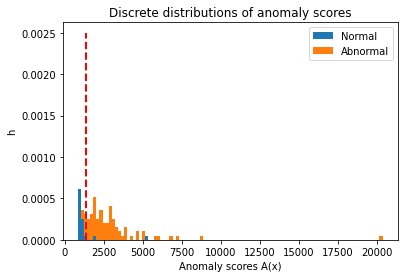

In [425]:
plt.hist([ano_score[np.array(label) == 0], ano_score[np.array(label) == 1]],
          bins=100, density=True, stacked=True,
          label=["Normal", "Abnormal"])
plt.title("Discrete distributions of anomaly scores")
plt.xlabel("Anomaly scores A(x)")
plt.ylabel("h")
plt.legend()
plt.vlines(best_thresh, 0, 0.0025, color='red', linestyle='--', linewidth=2)
plt.show()

In [18]:
Pre_cision = TP / (TP+FP)
Re_call = TP / (TP + FN)
Accu_racy = (TP + TN) / (TP + FN + FP + TN)

print("Precision: ", Pre_cision)
print("Recall : ", Re_call)
print("Accuracy: ", Accu_racy)

Precision:  0.2090032154340836
Recall :  0.9558823529411765
Accuracy:  0.8882405745062837


In [45]:
#                예측 N(정상)    예측 P(이상)
# 실제 N(정상)  True Negative    False Positive
# 실제 P(이상)  False Negative   True Positive

# True Positive Rate = TP / (FN + TP) : 제대로 예측한 positive / 실제 positive, 실제 이상 이미지 중 얼마나 많이 잡아냈느냐
# False Positive Rate = FP / (TN + FP) : 정상인데 이상으로 예측한 것 / 실제 negative, 실제 정상 이미지 중 이상으로 예측한 비율

In [101]:
DATASET_PATH = '/workspace/CAMPUS/TOFU_Box/'

mode = 'test'
fpattern1 = os.path.join(DATASET_PATH,  f'{mode}/NG/*/*.jpg')
fpaths1 = sorted(glob(fpattern1))

fpattern2 = os.path.join(DATASET_PATH,  f'{mode}/OK/*/*.jpg')
fpaths2 = sorted(glob(fpattern2))

print(len(fpaths1))
print(len(fpaths2))

550
400
